For z-CUT LNOI: no for the quasi-TE mode and ne for the quasi-TM mode, despite propagation direction

In [4]:
import laserfun as lf
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.constants import pi, c
import pychi
import pynlo
from pynlo import utility as ut

# pulse parameters
pulse_duration = 235e-15  #s 
pulse_energy = 900e-12
pulse_wavelength = 1560e-9

# simulation parameter
simulation_steps = 100
simulation_points = 2 ** 13
simulation_error = 1e-5

# waveguide parameters
wg_length = 14*1e-3
wg_width = 2.0  #um
wg_chi2 = 27e-12 *2
n2 = 1.8e-19
Alpha = 0


# mode parameters
data_tm = np.load(f"data_w_{wg_width}_e.npz")
data_te = np.load(f"data_w_{wg_width}_o.npz")
wls = data_te['wls'] * 1e-9
neff_te = data_te['neff_list_te']
aeff_te = data_te['aeff_list_te'] * 1e-12
neff_tm = data_tm['neff_list_tm']
aeff_tm = data_tm['aeff_list_tm']* 1e-12


# Calculate Gamma
def gamma_function(wavelength, aeff_list, wavelength_list):
    aeff_interp = scipy.interpolate.interp1d(wavelength_list, aeff_list, fill_value=(aeff_list[0], aeff_list[-1]),
                                             bounds_error=False)
    gamma = 2 * np.pi * n2 / (wavelength * aeff_interp(wavelength))
    return gamma

aeff_interp = scipy.interpolate.interp1d(wls, aeff_tm)
wg_aeff = aeff_interp(pulse_wavelength)


In [5]:
#--laserfun
# create the pulse:
p = lf.Pulse(pulse_type='gaussian', fwhm_ps=pulse_duration * 1e12, center_wavelength_nm=pulse_wavelength * 1e9,
             power_is_avg=False, epp=pulse_energy, GDD=False, TOD=False, FOD=False, npts=simulation_points)
p.add_noise()

# create the waveguide
gamma = gamma_function(pulse_wavelength, aeff_tm,wls)
print(gamma)
f = lf.Fiber(wg_length, center_wl_nm=pulse_wavelength * 1e9, dispersion_format='GVD',
             gamma_W_m=gamma, loss_dB_per_m=Alpha * 100)


def disp_function(z=0):
    return (wls * 1e9, neff_tm)


f.set_dispersion_function(disp_function, dispersion_format='n')

# propagate the pulse using the NLSE
results = lf.NLSE(p, f, raman=False, shock=True, nsaves=simulation_steps, rtol=simulation_error,
                  atol=simulation_error, print_status=True)
# Ploting
fig, axes = results.plot(wavelength=True, show=False, tlim=(-5, 5), flim=(500, 2500), units="dB", cparam=[50, 60])

plt.set_cmap('jet')
plt.show()


0.6326436107686373
   1.0% - 1.414e-04 m - 0.0 seconds
   2.0% - 2.828e-04 m - 0.0 seconds
   3.0% - 4.242e-04 m - 0.0 seconds
   4.0% - 5.657e-04 m - 0.0 seconds
   5.1% - 7.071e-04 m - 0.0 seconds
   6.1% - 8.485e-04 m - 0.0 seconds
   7.1% - 9.899e-04 m - 0.0 seconds
   8.1% - 1.131e-03 m - 0.1 seconds
   9.1% - 1.273e-03 m - 0.1 seconds
  10.1% - 1.414e-03 m - 0.1 seconds
  11.1% - 1.556e-03 m - 1.0 seconds


Exception: Integrator failed! Check the input parameters.

Propagate laser to the waveguide using pynlo

2.1473007681550365e-21
z: 1/100
z: 2/100
Discarded
Discarded
Discarded
z: 3/100
z: 4/100
z: 5/100
z: 6/100
z: 7/100
z: 8/100
z: 9/100
z: 10/100
z: 11/100
z: 12/100
z: 13/100
z: 14/100
z: 15/100
z: 16/100
z: 17/100
z: 18/100
z: 19/100
z: 20/100
z: 21/100
z: 22/100
z: 23/100
z: 24/100
z: 25/100
z: 26/100
z: 27/100
z: 28/100
z: 29/100
z: 30/100
z: 31/100
z: 32/100
z: 33/100
z: 34/100
z: 35/100
z: 36/100
z: 37/100
z: 38/100
z: 39/100
z: 40/100
Discarded
z: 41/100
z: 42/100
z: 43/100
z: 44/100
z: 45/100
z: 46/100
z: 47/100
z: 48/100
z: 49/100
z: 50/100
z: 51/100
z: 52/100
z: 53/100
z: 54/100
z: 55/100
Discarded
Discarded
Discarded
z: 56/100
z: 57/100
z: 58/100
z: 59/100
z: 60/100
z: 61/100
z: 62/100
z: 63/100
z: 64/100
z: 65/100
z: 66/100
z: 67/100
z: 68/100
z: 69/100
z: 70/100
Discarded
Discarded
Discarded
z: 71/100
z: 72/100
z: 73/100
z: 74/100
z: 75/100
z: 76/100
z: 77/100
z: 78/100
z: 79/100
z: 80/100
z: 81/100
z: 82/100
z: 83/100
z: 84/100
z: 85/100
Discarded
Discarded
Discarded
Discar

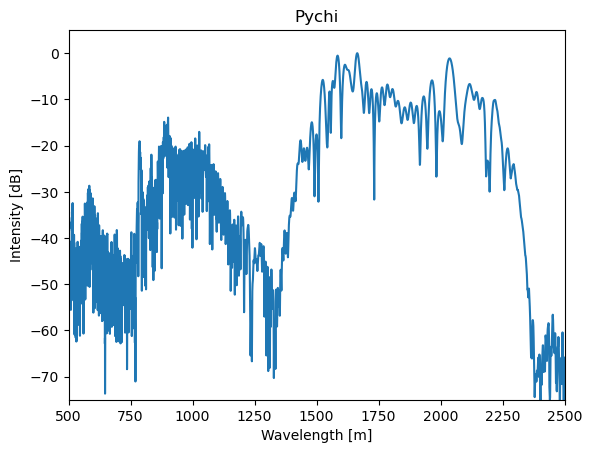

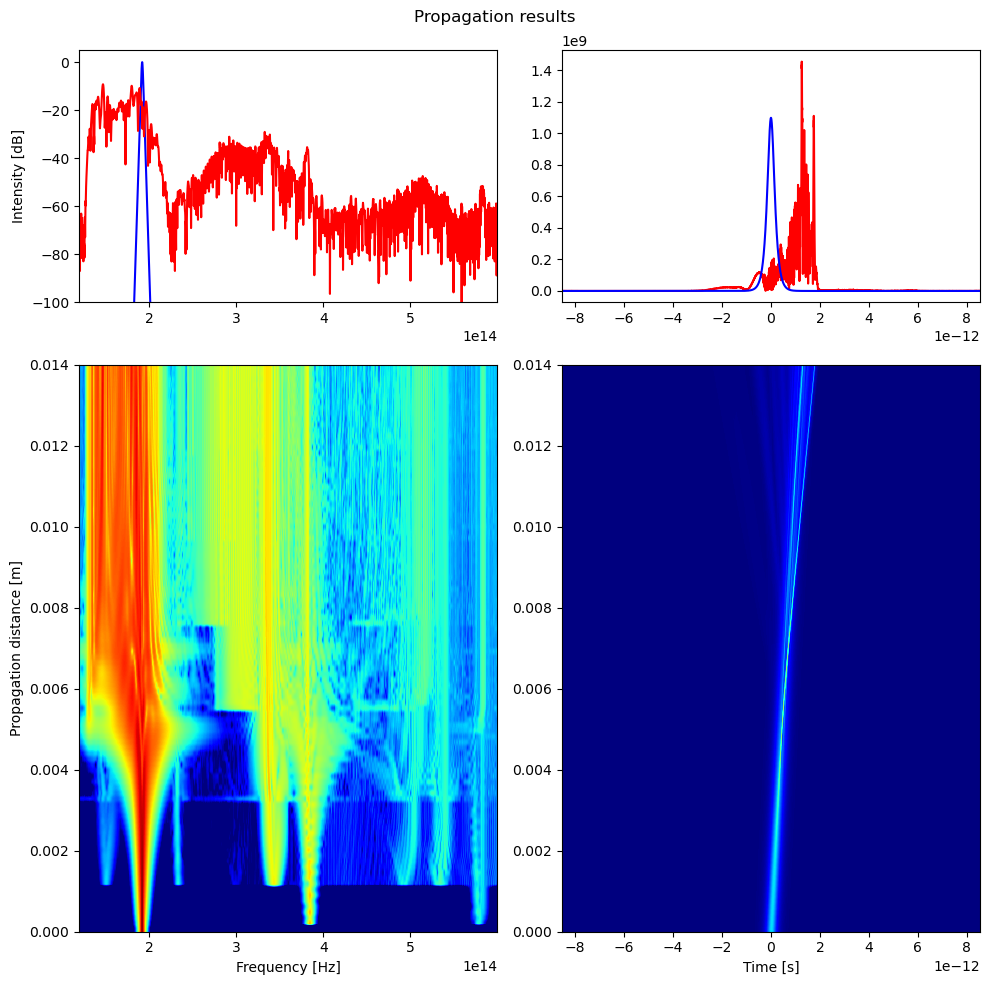

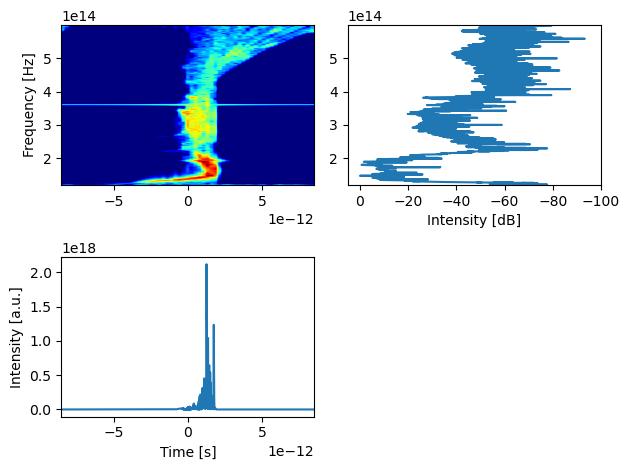

In [6]:

eps_0 = 8.8541878128e-12
wg_freq = c / wls
neff_interp = scipy.interpolate.interp1d(wls, neff_tm)
def wg_chi_3(z, freq):
    return 4 / 3 * neff_interp(c/freq) ** 2 * c * n2 * eps_0


print(wg_chi_3(0, c / pulse_wavelength))

### Prepare waveguide
waveguide = pychi.materials.Waveguide(wg_freq, neff_tm, wg_chi2, wg_chi_3, wg_aeff, wg_length, t_pts=simulation_points)

### Prepare input pulse
pulse_pychi = pychi.light.Sech(waveguide, pulse_duration, pulse_energy, pulse_wavelength)

### Prepare model
model = pychi.models.SpmChi2Chi3(waveguide, pulse_pychi)

### Prepare solver, solve
solver = pychi.solvers.Solver(model, z_pts=100)
solver.solve()

# Plot
plt.figure()
plt.plot(pulse_pychi.wl * 1e9, 20 * np.log10(pulse_pychi.spectrum_wl[-1] / np.amax(pulse_pychi.spectrum_wl[-1])))
plt.xlim(500, 2500)
plt.ylim(-75, 5)
plt.title('Pychi')
plt.xlabel('Wavelength [m]')
plt.ylabel('Intensity [dB]')

plt.set_cmap('jet')
plt.show()
pulse_pychi.plot_propagation()
# Results can also be accessed via pulse.z_save, pulse.freq, pulse.spectrum, pulse.waveform
# The refractive index and GVD can be seen with waveguide.plot_refractive_index()

[0.14652943 0.14668108 0.14683284 ... 3.13894688 3.13930184 3.13965681]


C:\Users\eliza\anaconda3\envs\SC-generation-stimulation\Lib\site-packages\pynlo\model.py:617: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self._rt_fig.show()
C:\Users\eliza\AppData\Local\Temp\ipykernel_15188\1690253427.py:50: RuntimeWarning: divide by zero encountered in log10
  p_t_dB = 10 * np.log10(np.abs(a_t) ** 2)


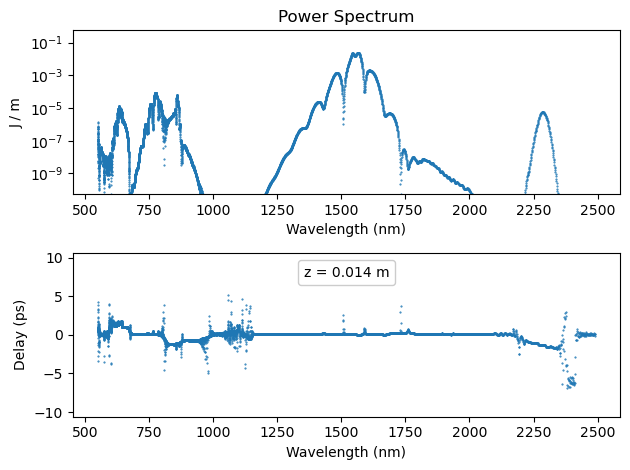

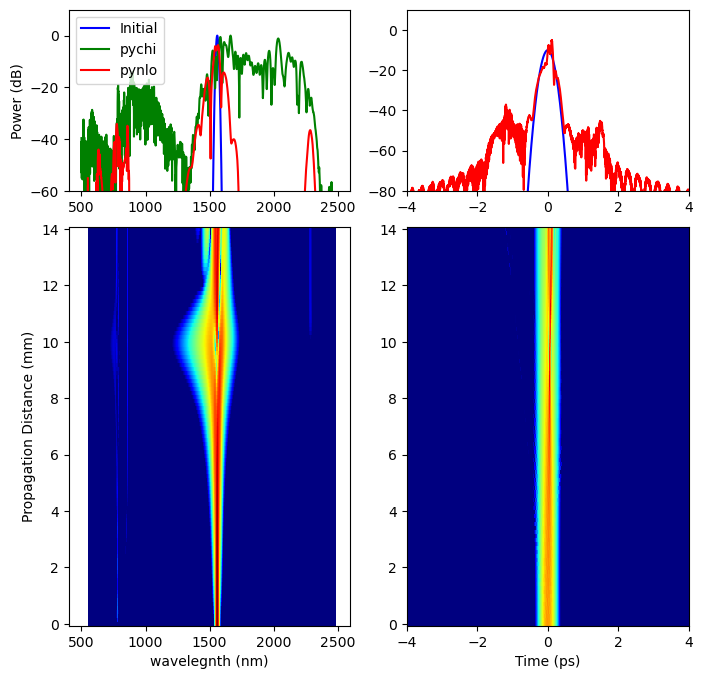

In [7]:
# pulse parameters
f_min = c / (2490e-9)  # c / l
f_max = c / (550e-9)  # c / l
f0 = c / pulse_wavelength  # c / 

pulse = pynlo.light.Pulse.Gaussian(simulation_points, f_min, f_max, f0, pulse_energy, pulse_duration, alias=2)  # alias = number of harmonic support by the real-valued time domain grid

#---- Phase Coefficient
w_grid = c / pulse.v_grid
n_eff = neff_interp(w_grid)
beta = n_eff * 2 * pi * pulse.v_grid / c

#---- 2nd-order nonlinearity
g2 = ut.chi2.g2_shg(f0, pulse.v_grid, n_eff, wg_aeff, wg_chi2)

# 3rd-Order Nonlinearity
gamma = gamma_function(w_grid, aeff_tm, wls)  #1/(W*m)
print(gamma)
g3 = ut.chi3.gamma_to_g3(pulse.v_grid, gamma)

mode = pynlo.medium.Mode(pulse.v_grid, beta, g3=g3, g2=g2)

#----build model
model = pynlo.model.UPE(pulse, mode)

#---- Estimate step size
dz = model.estimate_step_size(local_error=simulation_error)

pulse_out, z, a_t, a_v = model.simulate(wg_length, dz=dz, local_error=simulation_error, n_records=simulation_steps, plot="wvl")

fig = plt.figure(figsize=(8, 8))
ax0 = plt.subplot2grid((3, 2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3, 2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3, 2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3, 2), (1, 1), rowspan=2, sharex=ax1)

p_v_dB = 10 * np.log10(np.abs(a_v) ** 2)
p_v_dB -= p_v_dB.max()

w_grid = c / (pulse.v_grid) * 1e9
ax0.plot(w_grid, p_v_dB[0], color="b", label='Initial')
ax0.plot(pulse_pychi.wl * 1e9, 20 * np.log10(pulse_pychi.spectrum_wl[-1] / np.amax(pulse_pychi.spectrum_wl[-1])), color = "green", label="pychi")
ax0.plot(w_grid, p_v_dB[-1], color="r", label="pynlo")
ax0.legend()
ax2.pcolormesh(w_grid, 1e3 * z, p_v_dB,
               vmin=-40.0, vmax=0, shading="auto", cmap="jet")
ax0.set_ylim(bottom=-60, top=10)
ax2.set_xlabel('wavelegnth (nm)')

p_t_dB = 10 * np.log10(np.abs(a_t) ** 2)
p_t_dB -= p_t_dB.max()
ax1.plot(1e12 * pulse.t_grid, p_t_dB[0], color="b", label='Initial')
ax1.plot(1e12 * pulse.t_grid, p_t_dB[-1], color="r")
ax3.pcolormesh(1e12 * pulse.t_grid, 1e3 * z, p_t_dB,
               vmin=-40.0, vmax=0, shading="auto")

ax1.set_ylim(bottom=-80, top=10)
ax1.set_xlim(-4, 4)
ax3.set_xlabel('Time (ps)')

ax0.set_ylabel('Power (dB)')
ax2.set_ylabel('Propagation Distance (mm)')
plt.set_cmap('jet')
plt.show()
